<a href="https://colab.research.google.com/github/JAaron93/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/FrankenBERT_Labs37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading in our Tweets



In [1]:
!pip install pyforest
!pip install transformers
!pip install psycopg2-binary
!pip uninstall -y tensorflow-datasets
!pip install lit_nlp tfds-nightly transformers==4.1.1

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=6b4504b4f31f3527656083c395368ae80515b0273ddd1f87c42f1ae25802d987
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest
     |████████████████████████████████| 2.6 MB 13.5 MB/s 
     |████████████████████████████████| 3.3 MB 40.1 MB/s 
     |████████████████████████████████| 636 kB 44.9 MB/s 
     |████████████████████████████████| 895 kB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 3.4 MB 13.1 MB/s 
Found existing installation: tensorflow-datasets 4.0.1
Uninstalling tensorflow-datasets-4.0.1:
  Successfully uninstalled tensorflow-datasets-4.0.1
     |████████████████████████████████| 599 kB 11.8 MB/s 
     |████████████████████████████████| 4.0 MB 40.0 MB/s 
    

In [2]:
# Imports
from pyforest import *
pd.options.display.max_colwidth = 750

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lit_nlp import notebook

<IPython.core.display.Javascript object>

In [12]:
def rank_wrangle():
  '''
  Loads in both synthetic tweets generated from GPT-2 and authentic tweets from scraped from Twitter.
  Performs transformations for the sake of placing our data into a format amicable to NLP modeling.
  -----
  Training and test .csv files are contained within /Labs36_notebooks.
  rank2_syn.txt, rank3_syn.txt, and rank4_syn.txt are found in /synthetic_tweets
  -----
  Parameters 
  ------
  None
  Returns
  -------
  df: pandas dataframe
  Contains fully concatenated dataframe
  '''
  # Supplying our dataframes with proper labels
  column_headers = ['tweets', 'labels']
  # Reading in our three police force rank datasets
  df_rank2 = pd.read_csv("/content/rank2_syn.txt",
                       sep = '/',
                       names=column_headers)
  df_rank3 = pd.read_csv("/content/rank3_syn.txt",
                       sep = '/',
                       names=column_headers)
  df_rank4 = pd.read_csv("/content/rank4_syn.txt",
                       sep = '/',
                       names=column_headers)
  train = pd.read_csv('/content/training.csv')
  test = pd.read_csv('/content/test.csv')
  # Concatenating all of our datasets into one
  compiled = pd.concat([train, test, df_rank2, df_rank3, df_rank4])
  # Dropping unnecessary columns
  compiled.drop('Unnamed: 0', axis=1, inplace=True)
  compiled.drop('id', axis=1, inplace=True)
  # Discarding generated duplicates from GPT-2 while keeping the original Tweets
  compiled.drop_duplicates(subset='tweets', keep='first', inplace=True)

  return compiled

In [13]:
# Applying our function above and viewing the contents of our dataframe
force_ranks = rank_wrangle()
force_ranks

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,tweets,labels
0,"A New Mexico State Police officer killed two people in crisis within five weeks, and demands for accountability are mounting https://t.co/mFYfC7kTFQ",5
1,I found some police badge stickers at work and I’ve started asking every officer I see if they want one with their name on it. I think it’s funny every time and so do they so I will continue this,0
2,"According to media reports, police said they arrested Sharma after a complaint from animal welfare organisation People for Animals. | via @philstarlife https://t.co/DO5ZZlNJHs",1
3,"The male who has the knife is now running northbound, per caller.",0
4,Changing the assignments of already existing cops and diverting already existing resources means you wouldn’t have increase the police budget.,0
...,...,...
917,"Following the death of an unarmed driver at the hands of police, protesters gathered outside the Miami Police Department. Footage shows a woman screaming and in sufficient pain that another protester is needed to carry her away quickly. Other protesters come to aid her and are summarily pepper-sprayed.",4
920,"At a protest outside the ICE facility in Portland, protesters built a barricade and threw objects at ICE agents and officers. Federal agents then deployed tear gas and stun grenades against the crowd.",4
921,"Following the death of an unarmed driver at the hands of police, protesters gathered outside the Brooklyn Center police precinct. Around 9pm, police fired tear gas and rubber bullets into the crowd.",4
922,"A journalist with Mill City Citizen Media is shot to death outside a Shake Shack restaurant after refusing to leave the building. The man was wearing a press jacket and held a sign above his head saying he was not allowed to be on the internet. Police said the man’s name was James Borden and he was receiving medical attention while hospitalized. He was shot once through the head and died shortly afterward. Mill City is about an hour away from Portland./4\r\nFollowing the death of an unarmed driver at the hands of police, protesters gathered outside the Brooklyn Center police precinct. Police there had been called to the precinct multiple times about a large fight and other protesters disruptive behavior. Police had deployed tear gas and...",4


In [14]:
force_ranks.isnull().sum()

tweets    0
labels    0
dtype: int64

## Number of Tweets per Label - Visualized

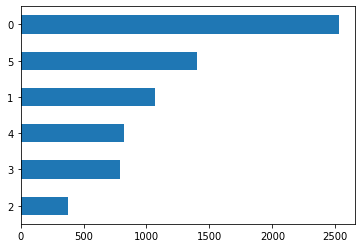

In [15]:
force_ranks.labels.value_counts(ascending=True).plot(kind='barh')

Ranks 2, 3, and 4 are still paltry in comparison to ranks 0, 1, & 5. However, the number we have here for each of these three ranks, >500, should still be enough to solve BERT's class imbalance.

# Preparing Data for BERT

Splitting dataframe into training and testing sets before converting to parquet for later reference/resource.

In [13]:
training, testing = train_test_split(force_ranks, test_size=0.2)

<IPython.core.display.Javascript object>

In [14]:
# Sanity Check
len(force_ranks) == len(training) + len(testing)

True

In [15]:
training.to_parquet('synthetic_training.parquet')
testing.to_parquet('synthetic_testing.parquet')
force_ranks.to_parquet('synthetic_complete.parquet')

# BERT - Training our NLP Multi Class Classification Model

In [17]:
def bert_trainer(df, output_dir: str, epochs: int):
    max_len = 280
    if torch.cuda.is_available():
        print("CUDA Active")
        device = torch.device("cuda")
    else:
        print("CPU Active")
        device = torch.device("cpu")
    sentences = df["tweets"].values
    labels = df["labels"].values
    tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased',
        do_lower_case=True,
    )
    inputs = [
        tokenizer.encode(sent, add_special_tokens=True) for sent in sentences
    ]
    inputs_ids = pad_sequences(
        inputs,
        maxlen=max_len,
        dtype="long",
        value=0,
        truncating="post",
        padding="post",
    )
    attention_masks = [
        [int(token_id != 0) for token_id in sent] for sent in inputs_ids
    ]
    train_inputs = torch.tensor(inputs_ids)
    train_labels = torch.tensor(labels)
    train_masks = torch.tensor(attention_masks)
    batch_size = 32
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=batch_size,
    )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=6,
        output_attentions=False,
        output_hidden_states=False,
    )
    if torch.cuda.is_available():
        model.cuda()
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )
    loss_values = []
    print('\nTraining...')
    for epoch_i in range(1, epochs + 1):
        print(f"\nEpoch: {epoch_i}")
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print(f"Average Loss: {avg_train_loss}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"\nSaving model to {output_dir}")
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print("Finished!")

In [1]:
bert_trainer(training, 'saved_model', epochs=50)

NameError: ignored